# Import Libraries

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset

In [2]:
# Load and Clean Data
df = pd.read_csv("data.csv")
df.columns = df.columns.str.strip()

In [3]:
df.shape

(6819, 96)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

In [5]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [6]:
df.isnull().sum().sum()

0

# correlation

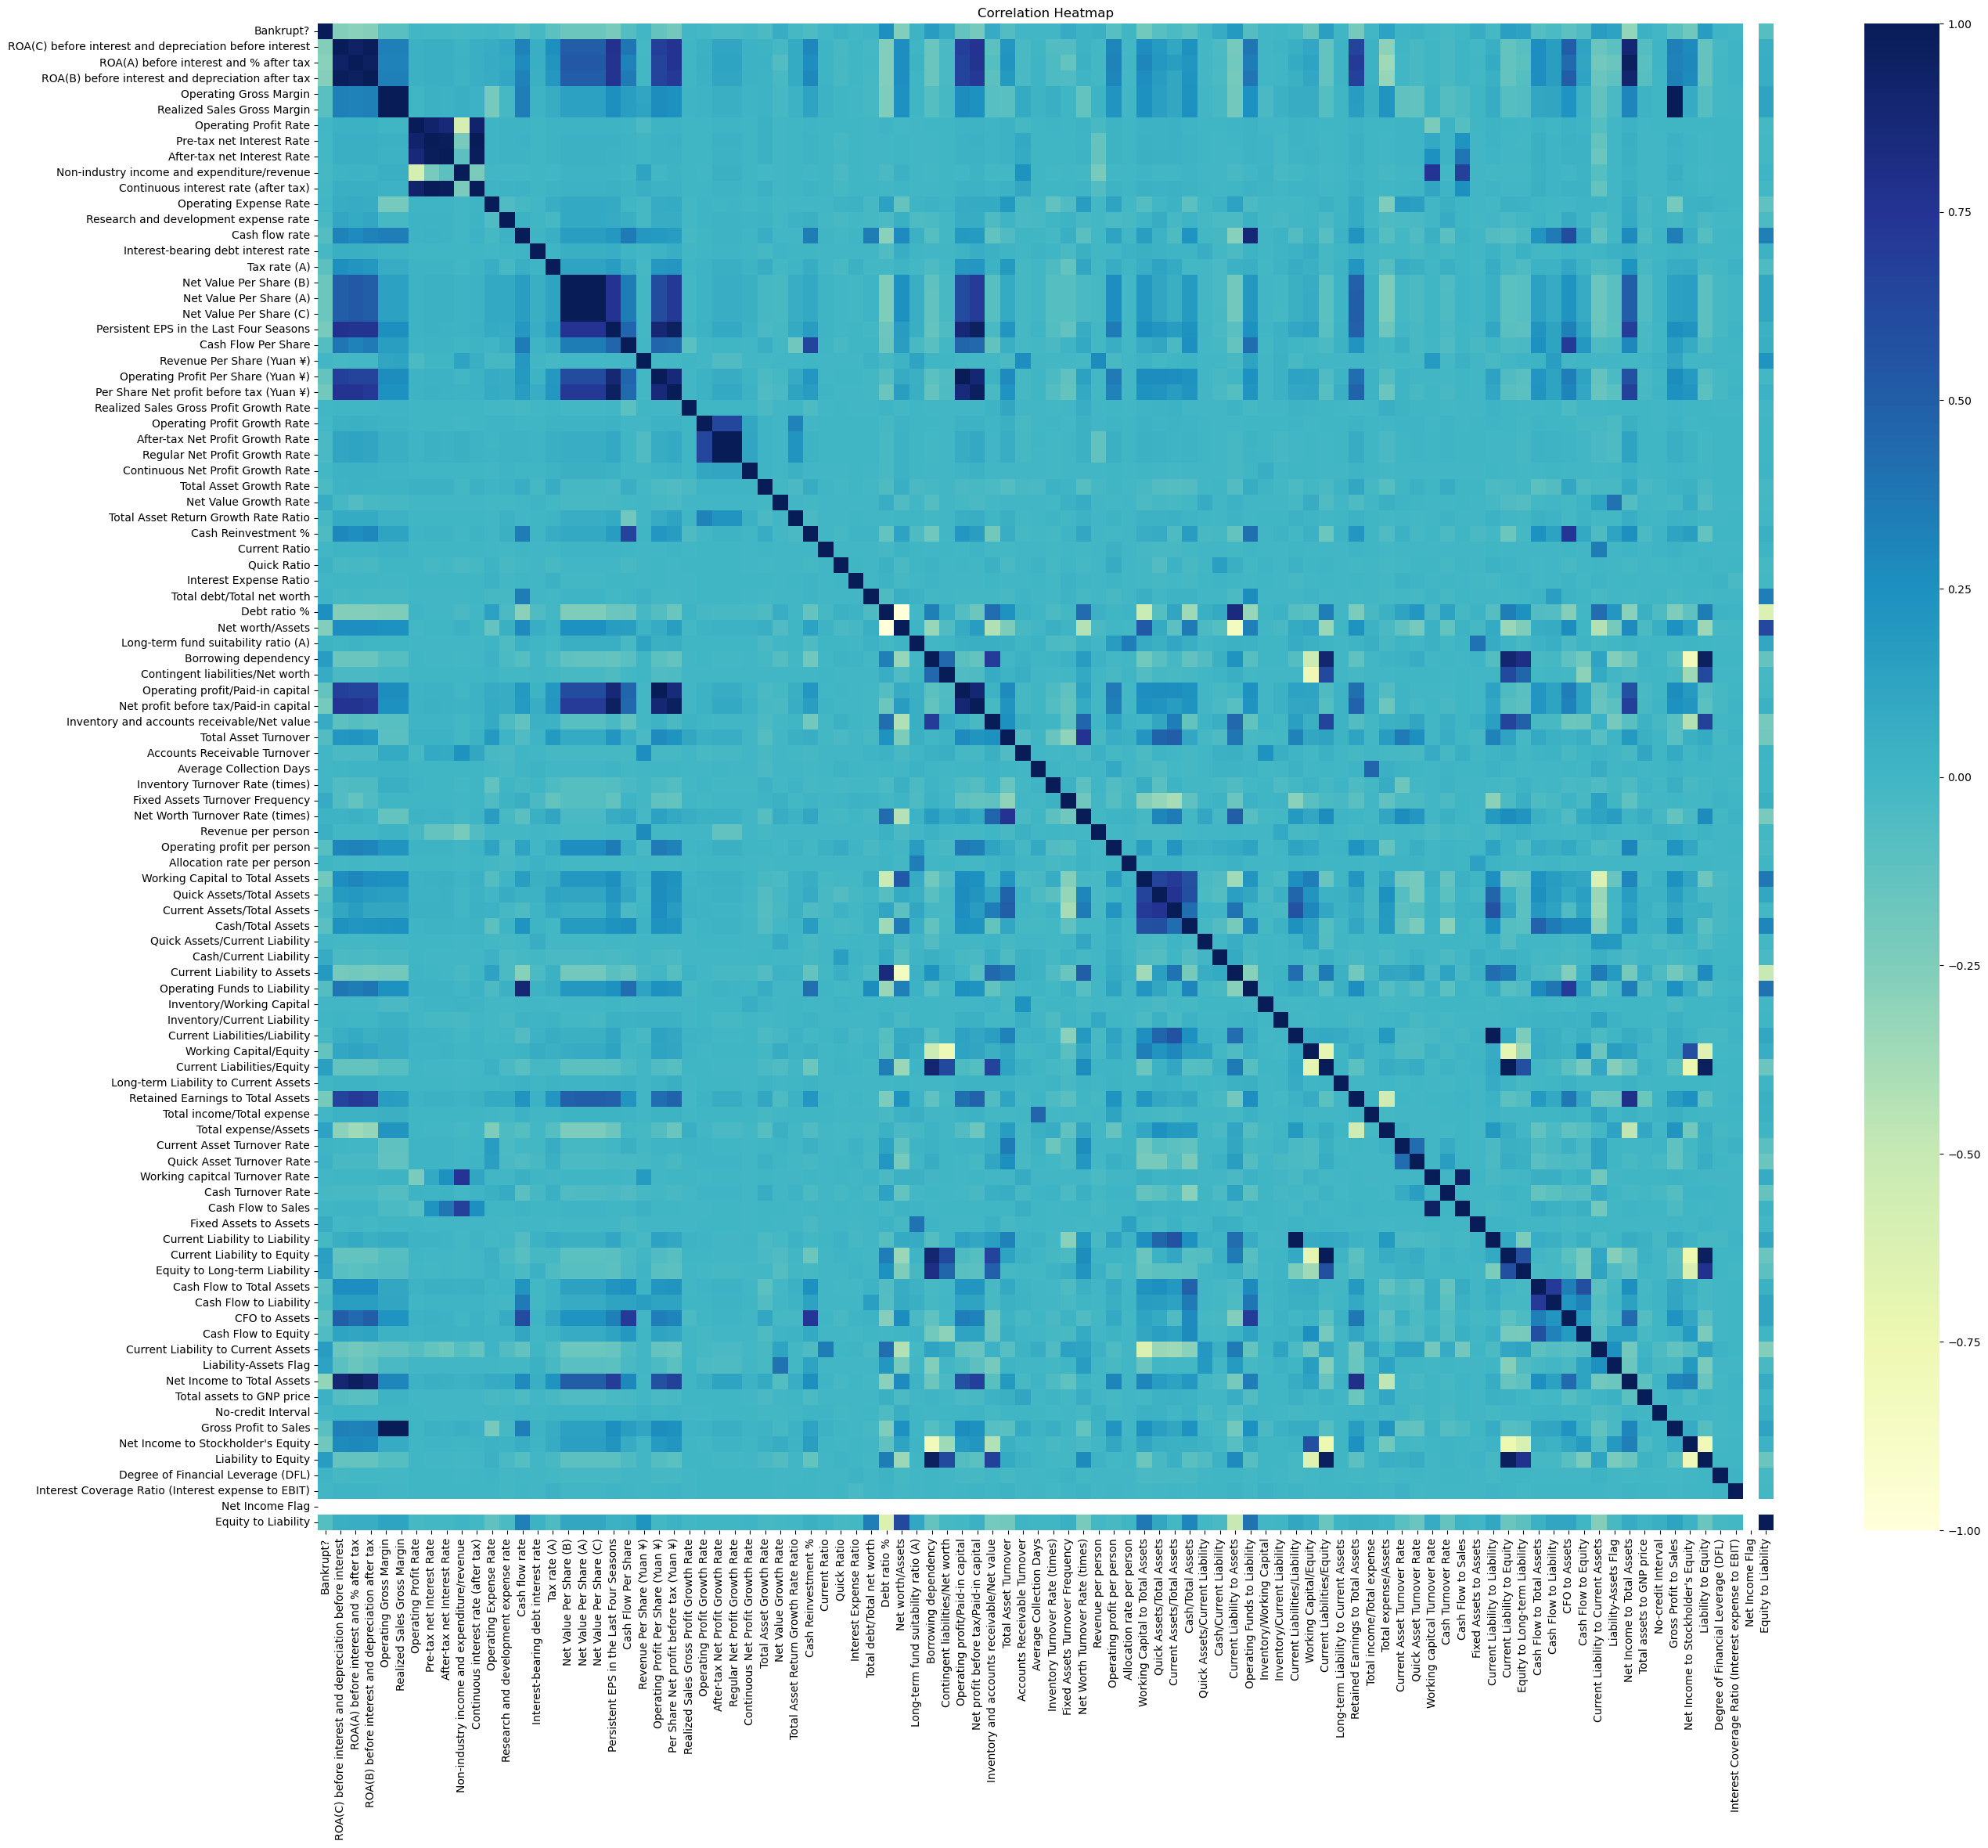

In [7]:
# Calculate the correlation matrix
corr_matrix = df.corr()
# Set the figure size
plt.figure(figsize=(30,25))
# Generate a heatmap with a different color map
sns.heatmap(corr_matrix, cmap='YlGnBu')  # You can try other color maps like 'viridis', 'plasma', 'inferno', etc.
# Add a title
plt.title("Correlation Heatmap")
# Show the plot
plt.show()

# Feature Selection

In [8]:
# Feature Selection based on Correlation
corr_matrix = df.corr()
corr_thresh = 0.15
corr_features = corr_matrix['Bankrupt?'].abs() >= corr_thresh
selected_features = corr_features[corr_features].index.tolist()
selected_features.remove('Bankrupt?')

X = df[selected_features]
y = df['Bankrupt?']

# Handling Class Imbalance

In [9]:
# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Models implementation

In [10]:
#  Model Setup
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=500, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}



# Models Evaluation

In [11]:
# Evaluate Models with Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    f1s, recalls, aucs = [], [], []

    for train_idx, test_idx in skf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
        y_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        f1s.append(f1_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        aucs.append(auc(*roc_curve(y_test, y_prob)[:2]))

    results.append({
        'Model': name,
        'F1 Score': np.mean(f1s),
        'Recall': np.mean(recalls),
        'AUC': np.mean(aucs)
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="Recall", ascending=False))



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5279, number of negative: 5279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 10558, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5279, number of negative: 5279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 10558, number of

# Hyperparameter Tuning of best Performing model

In [12]:
# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_resampled, y_resampled)
print("Best Random Forest Parameters:", grid.best_params_)



Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


# ROC Curves

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6599, number of negative: 6599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 13198, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


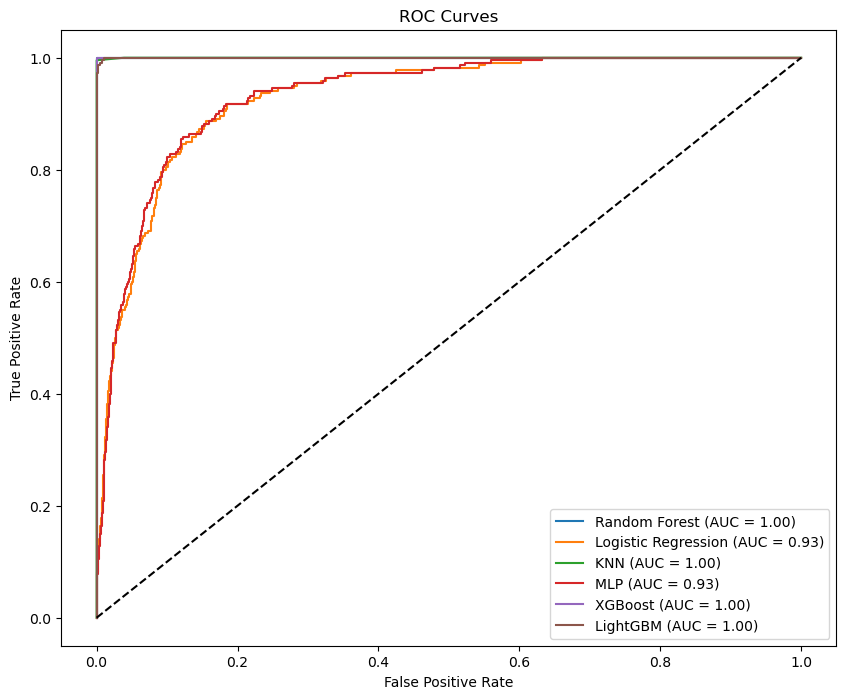

In [13]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_probs = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_probs)
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {model_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()




--- Confusion Matrix and Classification Report for Each Model ---


Model: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6599
           1       1.00      1.00      1.00       220

    accuracy                           1.00      6819
   macro avg       1.00      1.00      1.00      6819
weighted avg       1.00      1.00      1.00      6819



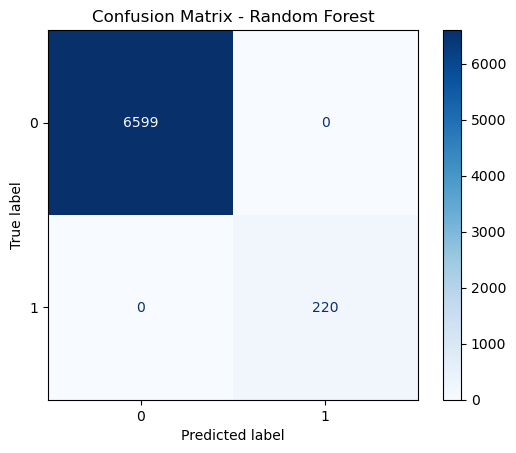


Model: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      6599
           1       0.17      0.87      0.28       220

    accuracy                           0.85      6819
   macro avg       0.58      0.86      0.60      6819
weighted avg       0.97      0.85      0.90      6819



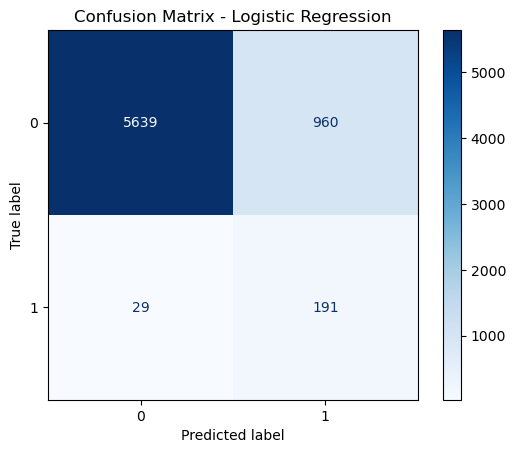


Model: KNN

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      6599
           1       0.32      1.00      0.49       220

    accuracy                           0.93      6819
   macro avg       0.66      0.96      0.73      6819
weighted avg       0.98      0.93      0.95      6819



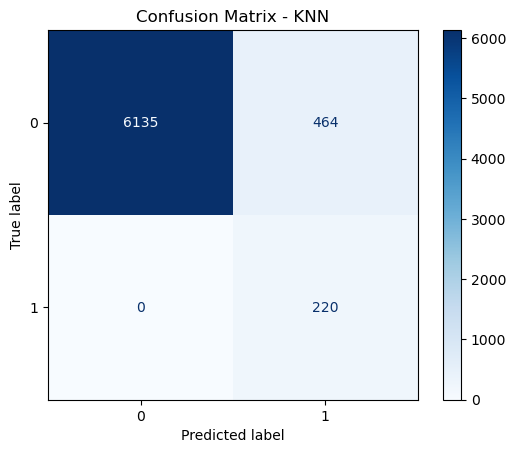


Model: MLP

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89      6599
           1       0.13      0.92      0.23       220

    accuracy                           0.80      6819
   macro avg       0.56      0.86      0.56      6819
weighted avg       0.97      0.80      0.87      6819



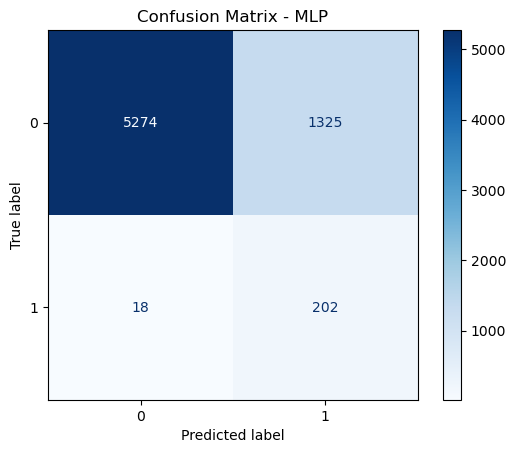


Model: XGBoost

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6599
           1       0.99      1.00      1.00       220

    accuracy                           1.00      6819
   macro avg       1.00      1.00      1.00      6819
weighted avg       1.00      1.00      1.00      6819



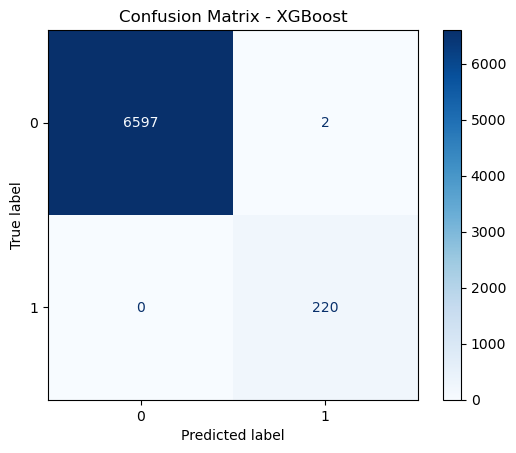


Model: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6599, number of negative: 6599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 13198, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6599
           1       0.68      1.00      0.81       220

    accuracy                           0.99      6819
   macro avg       0.84      0.99      0.90      6819
weighted avg       0.99      0.99      0.99      6819



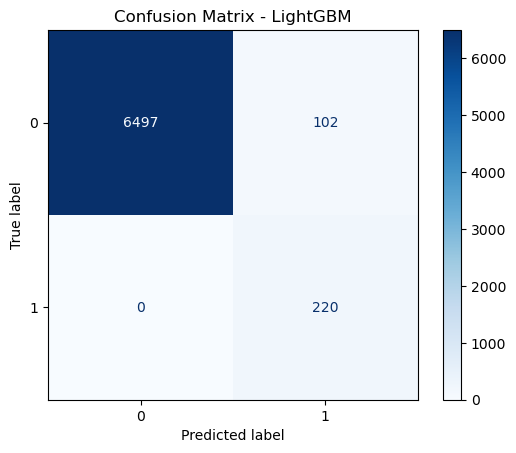

In [14]:
# Classification Report & Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

print("\n--- Confusion Matrix and Classification Report for Each Model ---\n")

for name, model in models.items():
    print(f"\nModel: {name}")
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()


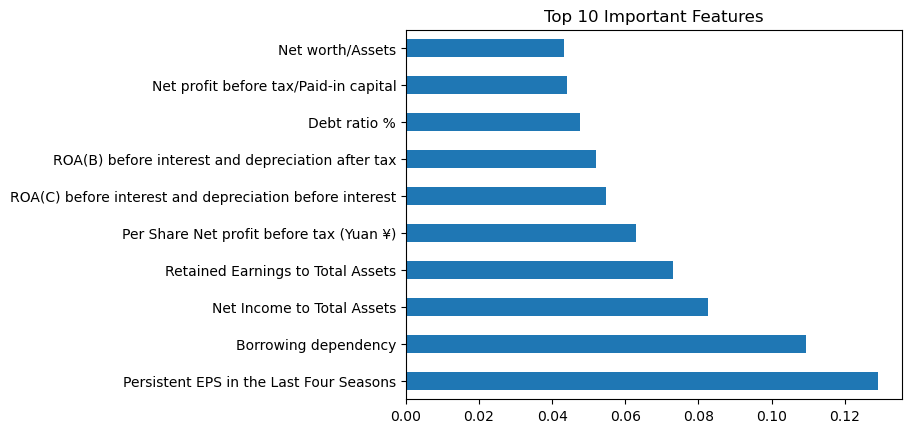

In [15]:
# Feature Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()


# Feature Interpretation

The most influential features, based on the Random Forest model, include:

- **Persistent EPS in the Last Four Seasons** and **Net Income to Total Assets**: These reflect consistent profitability and overall financial performance — crucial indicators of long-term viability.
- **Borrowing Dependency** and **Debt Ratio %**: High values in these features indicate heavy reliance on external debt, increasing financial risk and likelihood of default.
- **ROA(B)/ROA(C) before interest and depreciation**: These measure the company's operational profitability before financial and accounting adjustments, giving insight into core business health.
- **Retained Earnings to Total Assets**: Suggests how much profit is reinvested, which typically supports financial resilience.
- **Per Share Net Profit Before Tax**: Reflects earning capacity on a per-share basis, relevant for investor confidence.

In a financial analysis context, these features help assess solvency, profitability, and capital efficiency — all of which are critical when predicting potential bankruptcy.


# Conclusion



**Best Performing Models:**  
Multiple models, including **Random Forest**, **XGBoost**, **LightGBM**, and **KNN**, achieved perfect or near-perfect AUC scores (1.00), demonstrating exceptional predictive capability in identifying company bankruptcy. Among them, **Random Forest** stood out for its consistent F1-score and interpretability through feature importance, making it the most practical choice for further deployment.

**Real-World Potential:**  
With such high performance, this machine learning pipeline is highly suitable for real-world applications in credit risk analysis, investment due diligence, and early warning systems for financial institutions. The model can be applied directly to current corporate financial data to flag companies at risk with high accuracy.

**Key Strengths:**
- Outstanding classification performance with minimal false positives/negatives.
- Data preprocessing (e.g., SMOTE) ensured robustness even in imbalanced scenarios.
- Key financial metrics like profitability, leverage, and retained earnings were identified as top predictors — aligning well with domain knowledge.

**Recommendations:**
- Integrate explainability tools like **SHAP** to make predictions understandable for auditors, investors, or decision-makers.
- Retrain the model regularly on updated data to adapt to changing economic or sectoral trends.
- Combine this approach with business rules and human oversight for regulatory compliance and accountability.

This project validates that machine learning can deliver **enterprise-grade predictive performance** in financial risk management with the right data and tuning.
